# Basic outline of polymer loading with OpenFF and our tools

## Basic imports

In [1]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

import logging
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

## Defining paths to PDB and monomer template files

In [2]:
from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

mol_name = 'polyvinylchloride' # this should be swapped out for the target molecule (provided files exist)
mol_class = 'simple_polymers'

src_dir  = Path('cleaned_structures')
pdb_dir  = src_dir / 'pdbs'  / mol_class
mono_dir = src_dir / 'monos' / mol_class

pdb_path  = assemble_path(pdb_dir , mol_name, extension='pdb')
mono_path = assemble_path(mono_dir, mol_name, extension='json')

for path in (pdb_path, mono_path):
    assert(path.exists()) # make sure 

## Create Monomer Group

polyvinylchloride


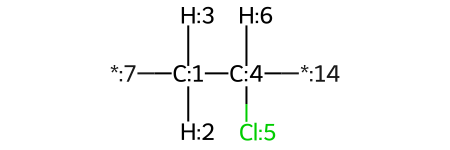

polyvinylchloride_TERM2


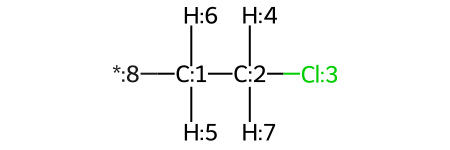

polyvinylchloride_TERM4


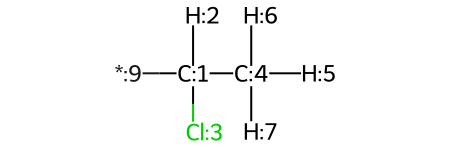

In [3]:
from polymerist.monomers import MonomerGroup

grp = MonomerGroup.from_file(mono_path)
for resname, mol in grp.iter_rdmols():
    print(resname)
    display(mol)

## Load topology with substructures, generate partition

In [4]:
from openff.toolkit import Topology, Molecule
from polymerist.openfftools import topology
from polymerist.residues.partition import partition

offtop = Topology.from_pdb(pdb_path, _custom_substructures=grp.monomers)
was_partitioned = partition(offtop)
assert(was_partitioned)

offmol = topology.get_largest_offmol(offtop)
display(offmol)

NGLWidget()

### Relabel partitioned molecule residues (necessary for GROMACS output)

In [5]:
unique_res_nums = sorted(set(atom.metadata['residue_number'] for atom in offmol.atoms))
res_num_remap = {
    res_num : i + 1 # new number must be non-zero
        for (i, res_num) in enumerate(unique_res_nums)
}

for atom in offmol.atoms:
    old_res_num = atom.metadata.pop('residue_number')
    atom.metadata['residue_number'] = res_num_remap[old_res_num]

### TODO : include RCT partial charging protocol (toolkit assignment is fine for now for small molecules)

## Load force field and create Interchange for format interconversion

In [6]:
from openff.toolkit import ForceField
from openff.interchange import Interchange
from polymerist.openfftools import FFDIR


groname = 'gromacs_demo'
grodir = Path('GROMACS_demo')
grodir.mkdir(exist_ok='true')

ff = ForceField(str(FFDIR / 'openff-2.0.0.offxml'))
inc = Interchange.from_smirnoff(force_field=ff, topology=offmol.to_topology())
inc.to_gromacs(prefix=str(grodir / groname))

2023-11-15 16:21:02.018 [INFO    :      parameters:line 2993] - Attempting to up-convert Electrostatics section from 0.3 to 0.4
2023-11-15 16:21:02.019 [INFO    :      parameters:line 3003] - Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.
